In [1]:
# !pip install scikit-learn
# !pip install matplotlib
# !pip install numpy
# !pip install scikit-image
# !pip install torch

## 11. Анализ главных компонент. Связь с SVD. Теорема Эккарта-Янга. Как применять PCA на практике.

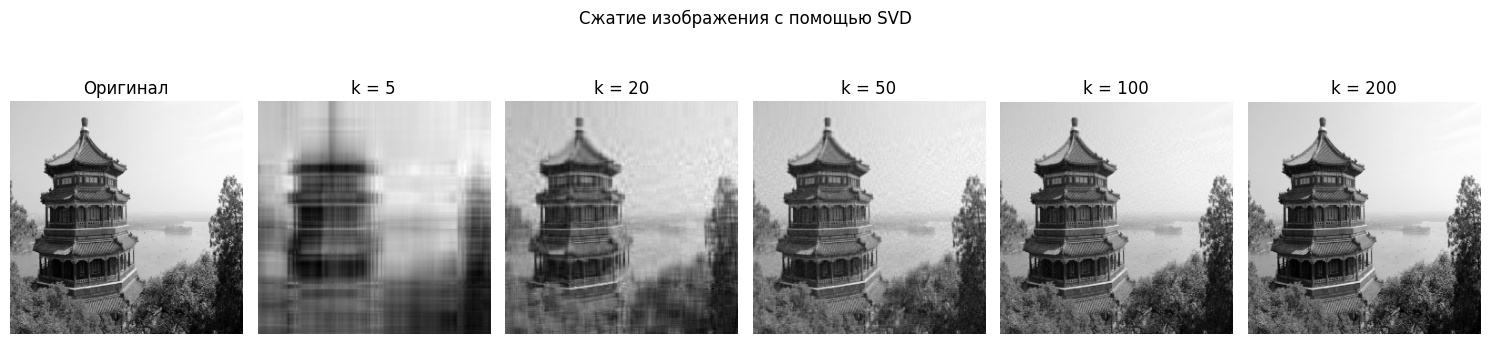

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_image
from skimage.color import rgb2gray
from skimage.transform import resize

# --- Загружаем и обрабатываем картинку
china = load_sample_image("china.jpg")   # встроенное изображение
gray = rgb2gray(china)                   # перевод в ч/б
gray = resize(gray, (256, 256), anti_aliasing=True)  # уменьшаем до квадрата

# --- SVD
U, S, VT = np.linalg.svd(gray, full_matrices=False)

# --- Восстановление при разных k
ks = [5, 20, 50, 100, 200]
fig, axes = plt.subplots(1, len(ks) + 1, figsize=(15, 4))

# Оригинал
axes[0].imshow(gray, cmap='gray')
axes[0].set_title("Оригинал")
axes[0].axis('off')

# При разных k
for i, k in enumerate(ks):
    approx = U[:, :k] @ np.diag(S[:k]) @ VT[:k, :]
    axes[i + 1].imshow(approx, cmap='gray')
    axes[i + 1].set_title(f"k = {k}")
    axes[i + 1].axis('off')

plt.suptitle("Сжатие изображения с помощью SVD")
plt.tight_layout()
plt.show()

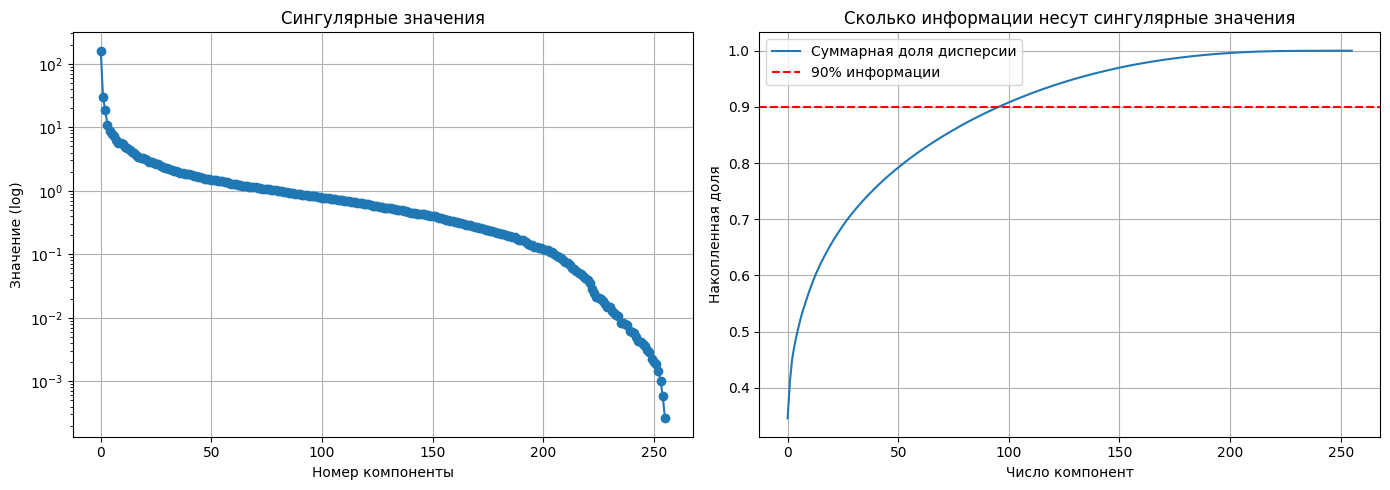

In [3]:
# Расчёт накопленной доли дисперсии
explained = np.cumsum(S) / np.sum(S)

# Отрисовка: сингулярные числа + накопленная доля
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# --- 1. Сами сингулярные числа (в лог масштабе)
ax1.plot(S, marker='o')
ax1.set_yscale("log")
ax1.set_title("Сингулярные значения")
ax1.set_xlabel("Номер компоненты")
ax1.set_ylabel("Значение (log)")
ax1.grid(True)

# --- 2. Накопленная доля дисперсии
ax2.plot(explained, label='Cуммарная доля дисперсии')
ax2.axhline(0.9, color='red', linestyle='--', label='90% информации')
ax2.set_xlabel("Число компонент")
ax2.set_ylabel("Накопленная доля")
ax2.set_title("Сколько информации несут сингулярные значения")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


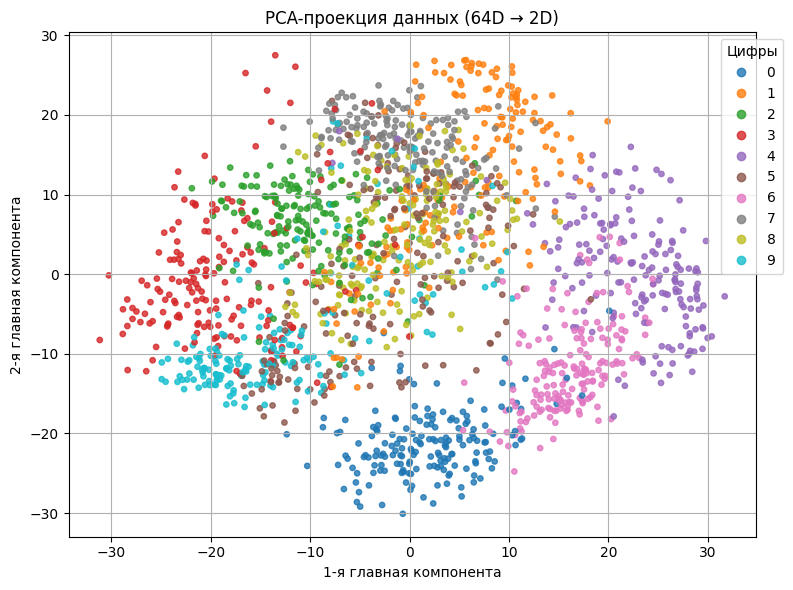

In [4]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# --- Загружаем данные
digits = load_digits()
X = digits.data       # 64 признака (8x8 пикселей)
y = digits.target     # метки (0-9)

# --- PCA до 2 компонент
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# --- Визуализация
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', s=15, alpha=0.8)
plt.legend(*scatter.legend_elements(), title="Цифры", loc="best", bbox_to_anchor=(1.05, 1))
plt.title("PCA-проекция данных (64D → 2D)")
plt.xlabel("1-я главная компонента")
plt.ylabel("2-я главная компонента")
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
X.shape

(1797, 64)

## 12. Этапы обучения, валидации и тестирования модели. Проблема переобучения, способы её обнаружения.


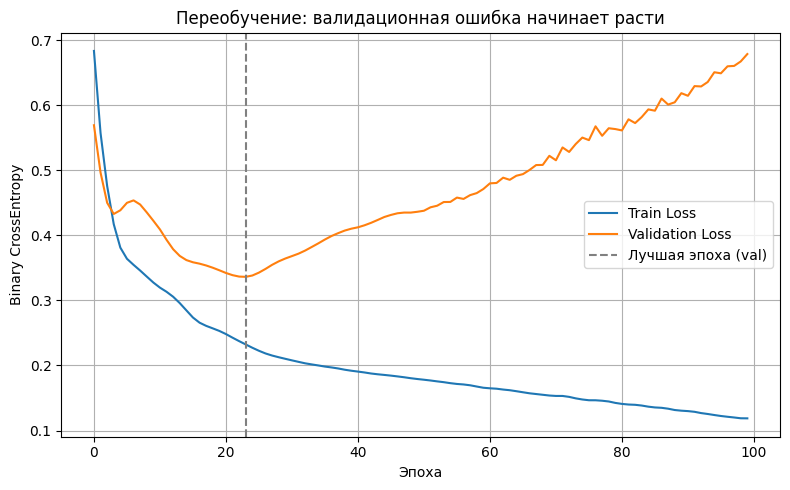

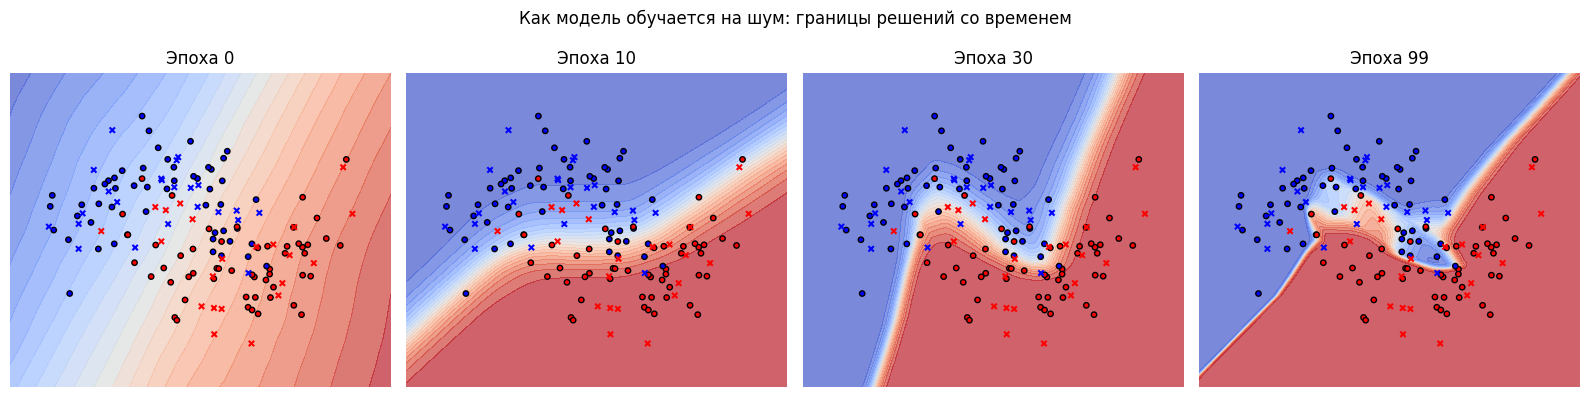

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Данные
X, y_true = make_moons(n_samples=150, noise=0.3, random_state=42)
# y_random = np.random.permutation(y_true)  # случайные метки!

# X_train, X_val, y_train, y_val = train_test_split(X, y_random, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y_true, test_size=0.3, random_state=42)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)

X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)

# --- 2. Модель
# h_size = 256
h_size = 100
model = nn.Sequential(
    nn.Linear(2, h_size),
    nn.ReLU(),
    nn.Linear(h_size, h_size),
    nn.ReLU(),
    nn.Linear(h_size, 1),
    nn.Sigmoid()
)

loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_losses, val_losses = [], []
snapshots = [0, 10, 30, 99]  # эпохи, для которых сохраним визуализацию

grids = np.meshgrid(
    np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 300),
    np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, 300)
)
grid_points = np.c_[grids[0].ravel(), grids[1].ravel()]
grid_tensor = torch.tensor(grid_points, dtype=torch.float32)

# --- 3. Обучение
snapshots_preds = []

for epoch in range(100):
    model.train()
    y_pred = model(X_train_t)
    loss = loss_fn(y_pred, y_train_t)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_t)
        val_loss = loss_fn(val_pred, y_val_t)
        if epoch in snapshots:
            pred_grid = model(grid_tensor).reshape(300, 300)
            snapshots_preds.append((epoch, pred_grid.numpy()))
    
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

# --- 4. График потерь
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axvline(np.argmin(val_losses), linestyle='--', color='gray', label='Лучшая эпоха (val)')
plt.title("Переобучение: валидационная ошибка начинает расти")
plt.xlabel("Эпоха")
plt.ylabel("Binary CrossEntropy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 5. Визуализация данных + предсказания
fig, axes = plt.subplots(1, len(snapshots_preds), figsize=(16, 4))
for ax, (epoch, Z) in zip(axes, snapshots_preds):
    ax.contourf(grids[0], grids[1], Z, levels=20, cmap='coolwarm', alpha=0.7)
    ax.scatter(*X_train.T, c=y_train, cmap='bwr', s=15, edgecolor='k', label='Train')
    ax.scatter(*X_val.T, c=y_val, cmap='bwr', marker='x', s=15, label='Val')
    ax.set_title(f"Эпоха {epoch}")
    ax.axis('off')
plt.suptitle("Как модель обучается на шум: границы решений со временем")
plt.tight_layout()
plt.show()


In [7]:
X.shape

(150, 2)

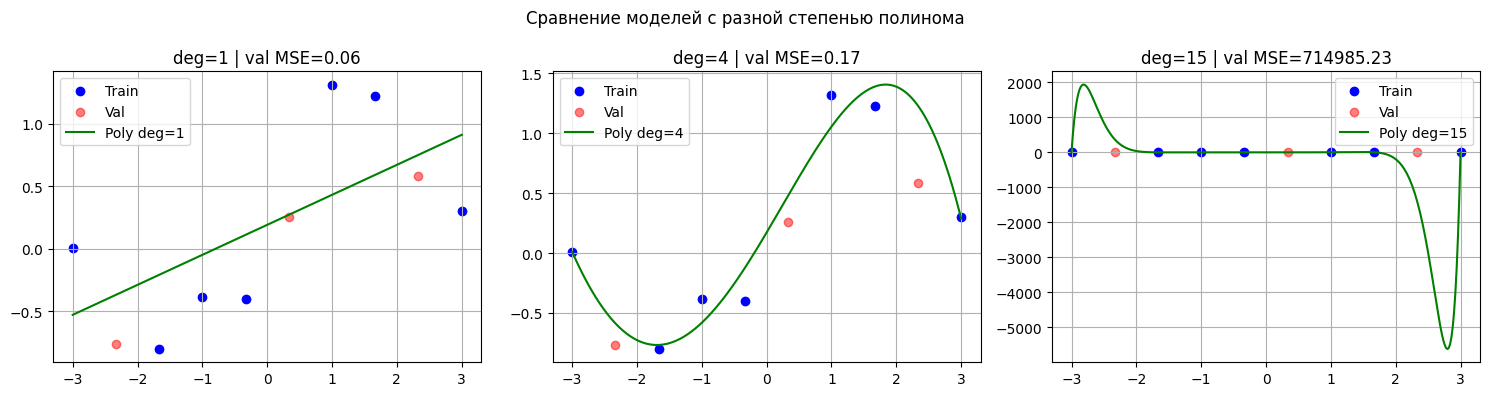

{1: 0.0623793189026051, 4: 0.16693688909602888, 15: 714985.2317858242}

In [8]:
# Повторный запуск после сброса состояния
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# --- 1. Генерируем данные
np.random.seed(42)
X = np.linspace(-3, 3, 10).reshape(-1, 1)  # мало точек
y = np.sin(X).ravel() + 0.3 * np.random.randn(*X.shape).ravel()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# --- 2. Обучаем модели с разной степенью полинома
degrees = [1, 4, 15]
preds = {}
val_errors = {}

x_plot = np.linspace(-3, 3, 300).reshape(-1, 1)

plt.figure(figsize=(15, 4))

for i, deg in enumerate(degrees):
    model = make_pipeline(PolynomialFeatures(degree=deg), LinearRegression())
    model.fit(X_train, y_train)
    
    y_plot = model.predict(x_plot)
    y_val_pred = model.predict(X_val)
    val_errors[deg] = mean_squared_error(y_val, y_val_pred)
    
    plt.subplot(1, 3, i + 1)
    plt.scatter(X_train, y_train, label='Train', color='blue')
    plt.scatter(X_val, y_val, label='Val', color='red', alpha=0.5)
    plt.plot(x_plot, y_plot, color='green', label=f"Poly deg={deg}")
    plt.title(f"deg={deg} | val MSE={val_errors[deg]:.2f}")
    plt.legend()
    plt.grid(True)

plt.suptitle("Сравнение моделей с разной степенью полинома")
plt.tight_layout()
plt.show()

val_errors
# {1: 0.0623793189026051, 4: 0.16693688909602888, 15: 714985.2317858242}

## 13. Стратегии валидации. Кросс-валидация. Утечки данных.


In [9]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

# --- Данные: много признаков, немного информативных
X, y = make_classification(
    n_samples=1000, n_features=500, n_informative=30,
    random_state=42, shuffle=False
)

# --- ⚠️ Утечка: отбор признаков ДО cross-validation
selector = SelectKBest(score_func=f_classif, k=50)
X_leak = selector.fit_transform(X, y)

model = RandomForestClassifier(random_state=42)
scores_leak = cross_val_score(model, X_leak, y, cv=5)

# --- ✅ Честно: отбор фич ВНУТРИ кросс-валидации
pipeline = make_pipeline(
    SelectKBest(score_func=f_classif, k=50),
    RandomForestClassifier(random_state=42)
)
scores_clean = cross_val_score(pipeline, X, y, cv=5)

print(f"⚠️ CV accuracy с утечкой:  {scores_leak.mean():.3f}")
print(f"✅ CV accuracy без утечки: {scores_clean.mean():.3f}")

# ⚠️ CV accuracy с утечкой:  0.787
# ✅ CV accuracy без утечки: 0.754

⚠️ CV accuracy с утечкой:  0.787
✅ CV accuracy без утечки: 0.754


## 14. Компромисс смещения-дисперсии (Bias-variance trade-off).


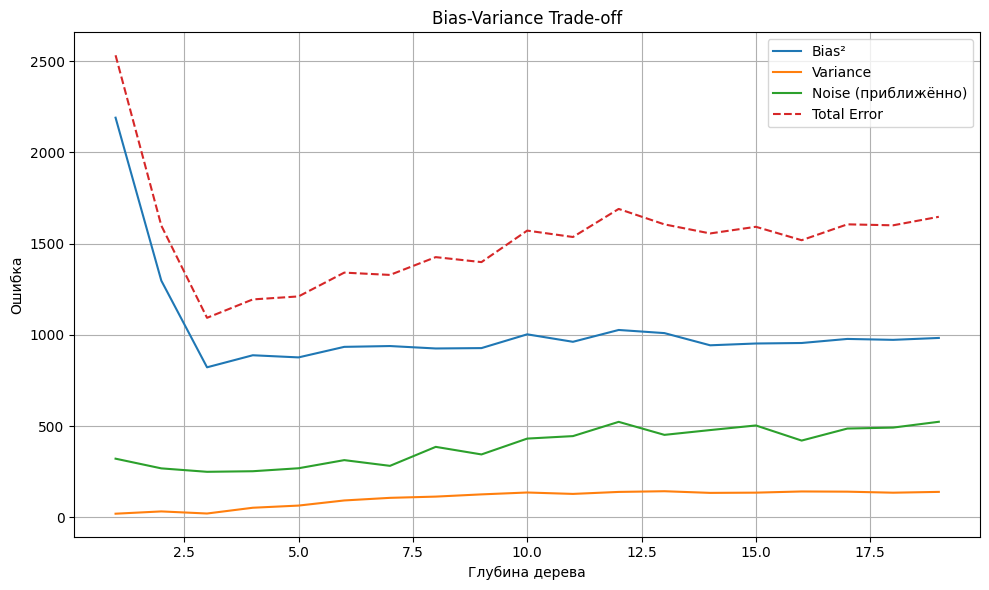

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# --- Данные
X_all, y_all = make_regression(n_samples=1000, n_features=1, noise=15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.3, random_state=42)
X_clean, y_clean = make_regression(n_samples=300, n_features=1, noise=0, random_state=42)
true_model = LinearRegression().fit(X_clean, y_clean)

X_test = np.linspace(X_all.min(), X_all.max(), 200).reshape(-1, 1)
true_y = true_model.predict(X_test)

# --- Bias², Variance, Noise
depths = range(1, 20)
n_models = 100
biases, variances, noises = [], [], []
models_by_depth = {d: [] for d in [1, 4, 10]}

for d in depths:
    preds = []
    for _ in range(n_models):
        X_boot, y_boot = resample(X_train, y_train)
        model = DecisionTreeRegressor(max_depth=d)
        model.fit(X_boot, y_boot)
        y_pred = model.predict(X_test)
        preds.append(y_pred)
        if d in models_by_depth and len(models_by_depth[d]) < 50:
            models_by_depth[d].append(y_pred)
    preds = np.array(preds)
    mean_preds = preds.mean(axis=0)
    bias2 = ((mean_preds - true_y) ** 2).mean()
    var = preds.var(axis=0).mean()
    noise = np.var(y_val - model.predict(X_val))  # приближённо
    biases.append(bias2)
    variances.append(var)
    noises.append(noise)

# --- График ошибок
plt.figure(figsize=(10, 6))
plt.plot(depths, biases, label='Bias²')
plt.plot(depths, variances, label='Variance')
plt.plot(depths, noises, label='Noise (приближённо)')
plt.plot(depths, np.array(biases) + np.array(variances) + np.array(noises),
         label='Total Error', linestyle='--')
plt.xlabel("Глубина дерева")
plt.ylabel("Ошибка")
plt.title("Bias-Variance Trade-off")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


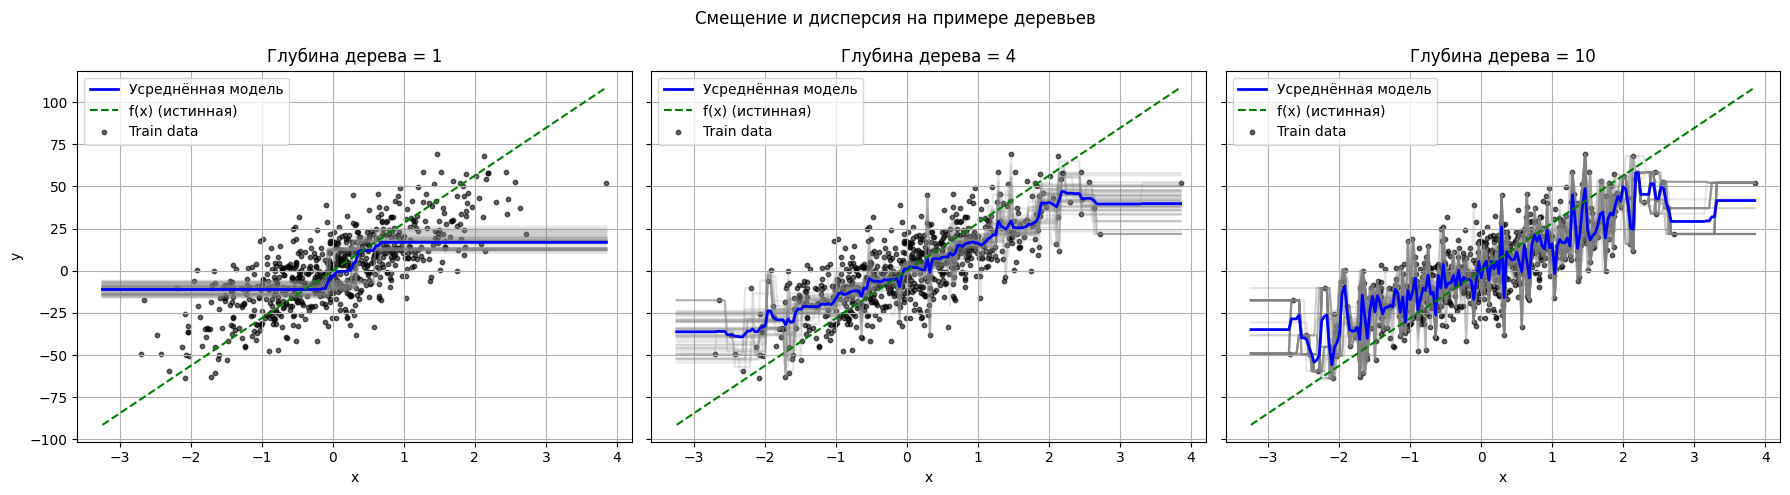

In [11]:
# --- Визуализация моделей
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for ax, d in zip(axes, [1, 4, 10]):
    all_preds = np.array(models_by_depth[d])
    for y_pred in all_preds:
        ax.plot(X_test.ravel(), y_pred, color='gray', alpha=0.2)
    ax.plot(X_test.ravel(), all_preds.mean(axis=0), color='blue', linewidth=2, label='Усреднённая модель')
    ax.plot(X_test.ravel(), true_y, color='green', linestyle='--', label='f(x) (истинная)')
    ax.scatter(X_train, y_train, s=10, color='black', alpha=0.6, label='Train data')
    ax.set_title(f"Глубина дерева = {d}")
    ax.set_xlabel("x")
    ax.legend()
    ax.grid(True)

axes[0].set_ylabel("y")
plt.suptitle("Смещение и дисперсия на примере деревьев")
plt.tight_layout()
plt.show()


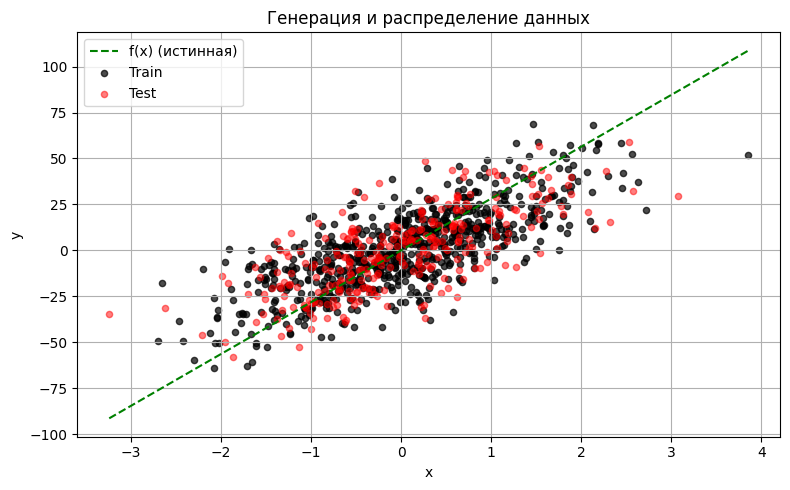

In [12]:
# Визуализация обучающих и тестовых данных на фоне регрессионной прямой
plt.figure(figsize=(8, 5))

# Линия истинной функции
plt.plot(X_test, true_y, color='green', linestyle='--', label='f(x) (истинная)')

# Обучающие и тестовые данные
plt.scatter(X_train, y_train, color='black', s=20, alpha=0.7, label='Train')
plt.scatter(X_val, y_val, color='red', s=20, alpha=0.5, label='Test')

plt.xlabel("x")
plt.ylabel("y")
plt.title("Генерация и распределение данных")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 15. Процедура построения дерева решений (Decision tree). 


In [13]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Загружаем датасет
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Свое дерево решений
class Node:
    def __init__(self, gini, samples, value, feature_index=None, threshold=None, left=None, right=None):
        self.gini = gini
        self.samples = samples
        self.value = value
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right

class MyDecisionTreeClassifier:
    def __init__(self, max_depth=3, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.feature_importances_ = None
        self.tree_ = None

    def fit(self, X, y):
        self.n_classes_ = len(set(y))
        self.n_features_ = X.shape[1]
        self.feature_importances_ = np.zeros(self.n_features_)
        self.tree_ = self._grow_tree(X, y)
    
    def _gini(self, y):
        m = len(y)
        return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in np.unique(y))

    def _best_split(self, X, y):
        m, n = X.shape
        if m <= 1:
            return None, None

        best_gini = 1.0
        best_idx, best_thr = None, None
        parent_gini = self._gini(y)

        for idx in range(n):
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            num_left = [0] * self.n_classes_
            num_right = np.bincount(classes, minlength=self.n_classes_)
            for i in range(1, m):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum((num_left[x] / i) ** 2 for x in range(self.n_classes_))
                gini_right = 1.0 - sum((num_right[x] / (m - i)) ** 2 for x in range(self.n_classes_))
                gini = (i * gini_left + (m - i) * gini_right) / m

                if thresholds[i] == thresholds[i - 1]:
                    continue

                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2
                    impurity_reduction = parent_gini - gini
                    self.feature_importances_[idx] += impurity_reduction

        return best_idx, best_thr

    def _grow_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes_)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(
            gini=self._gini(y),
            samples=len(y),
            value=num_samples_per_class
        )

        if depth < self.max_depth and len(y) >= self.min_samples_split and node.gini > 0:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] <= thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node

    def _predict(self, inputs):
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return np.argmax(node.value)

    def predict(self, X):
        return np.array([self._predict(inputs) for inputs in X])

# Обучение и сравнение
my_tree = MyDecisionTreeClassifier(max_depth=3)
my_tree.fit(X_train, y_train)
y_pred_my = my_tree.predict(X_test)

sk_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
sk_tree.fit(X_train, y_train)
y_pred_sk = sk_tree.predict(X_test)

# Сравнение результатов
acc_my = accuracy_score(y_test, y_pred_my)
acc_sk = accuracy_score(y_test, y_pred_sk)
print(f"{acc_my=} {acc_sk=}")
# acc_my=0.9590643274853801 acc_sk=0.9649122807017544


importances_df = pd.DataFrame({
    "Feature": feature_names,
    "MyTree": my_tree.feature_importances_ / np.sum(my_tree.feature_importances_),
    "Sklearn": sk_tree.feature_importances_
}).sort_values(by="MyTree", ascending=False)

importances_df

# Feature	MyTree	Sklearn
# 0	mean radius	0.637033	0.000000
# 7	mean concave points	0.260352	0.809978
# 2	mean perimeter	0.031954	0.000000
# 1	mean texture	0.030274	0.025169
# 6	mean concavity	0.020749	0.000000
# 20	worst radius	0.009949	0.043482
# 21	worst texture	0.002868	0.066145
# 23	worst area	0.001924	0.040310
# 22	worst perimeter	0.001833	0.000000
# 3	mean area	0.001694	0.000000
# 10	radius error	0.001371	0.000000

acc_my=0.9590643274853801 acc_sk=0.9649122807017544


,Feature,MyTree,Sklearn
0,mean radius,0.637033,0.000000
7,mean concave points,0.260352,0.809978
2,mean perimeter,0.031954,0.000000
1,mean texture,0.030274,0.025169
6,mean concavity,0.020749,0.000000
20,worst radius,0.009949,0.043482
21,worst texture,0.002868,0.066145
23,worst area,0.001924,0.040310
22,worst perimeter,0.001833,0.000000
3,mean area,0.001694,0.000000


## 16. Критерии информации. Критерии энтропии, неопределенности Джини.


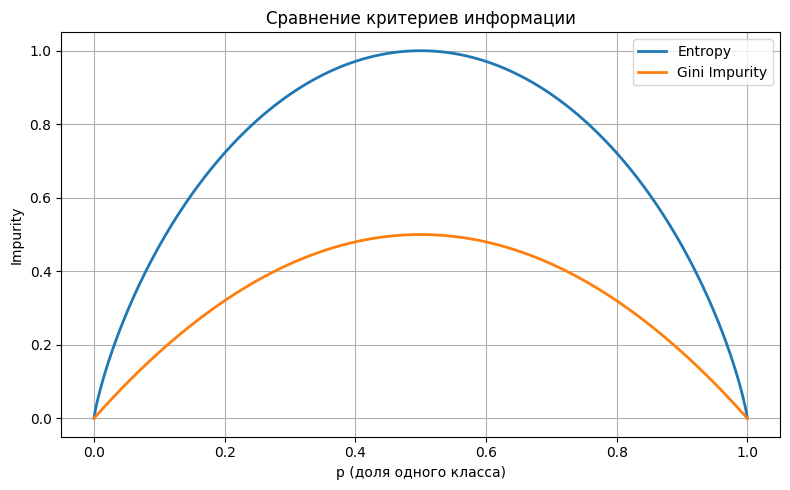

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Вероятности для одного из классов (например, класс 1)
p = np.linspace(0, 1, 500)

# Энтропия (Shannon entropy)
entropy = -p * np.log2(p + 1e-9) - (1 - p) * np.log2(1 - p + 1e-9)

# Джини
gini = 2 * p * (1 - p)

# Визуализация
plt.figure(figsize=(8, 5))
plt.plot(p, entropy, label='Entropy', linewidth=2)
plt.plot(p, gini, label='Gini Impurity', linewidth=2)
plt.xlabel("p (доля одного класса)")
plt.ylabel("Impurity")
plt.title("Сравнение критериев информации")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 17. Ансамблевые методы. Бутстрап (bootstrap). Бэггинг (bagging). Стекинг (stacking)


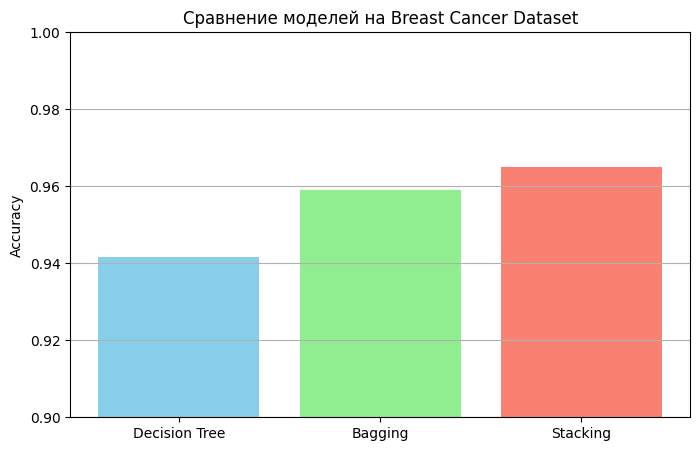

(0.9415204678362573, 0.9590643274853801, 0.9649122807017544)

In [15]:
# Импортируем библиотеки
from sklearn.ensemble import BaggingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Загружаем данные
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 1. Обычное дерево
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
acc_tree = accuracy_score(y_test, y_pred_tree)

# 2. Бэггинг с деревьями
bag = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, random_state=42)
bag.fit(X_train, y_train)
y_pred_bag = bag.predict(X_test)
acc_bag = accuracy_score(y_test, y_pred_bag)

# 3. Стекинг: дерево + SVM → логистическая регрессия
stack = StackingClassifier(
    estimators=[("dt", DecisionTreeClassifier()), ("svm", SVC(probability=True))],
    final_estimator=LogisticRegression(),
    cv=5
)
stack.fit(X_train, y_train)
y_pred_stack = stack.predict(X_test)
acc_stack = accuracy_score(y_test, y_pred_stack)

# Визуализация сравнения
models = ['Decision Tree', 'Bagging', 'Stacking']
accuracies = [acc_tree, acc_bag, acc_stack]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0.9, 1.0)
plt.ylabel("Accuracy")
plt.title("Сравнение моделей на Breast Cancer Dataset")
plt.grid(axis='y')
plt.show()

# Выведем точности отдельно
acc_tree, acc_bag, acc_stack
# (0.9415204678362573, 0.9590643274853801, 0.9649122807017544)

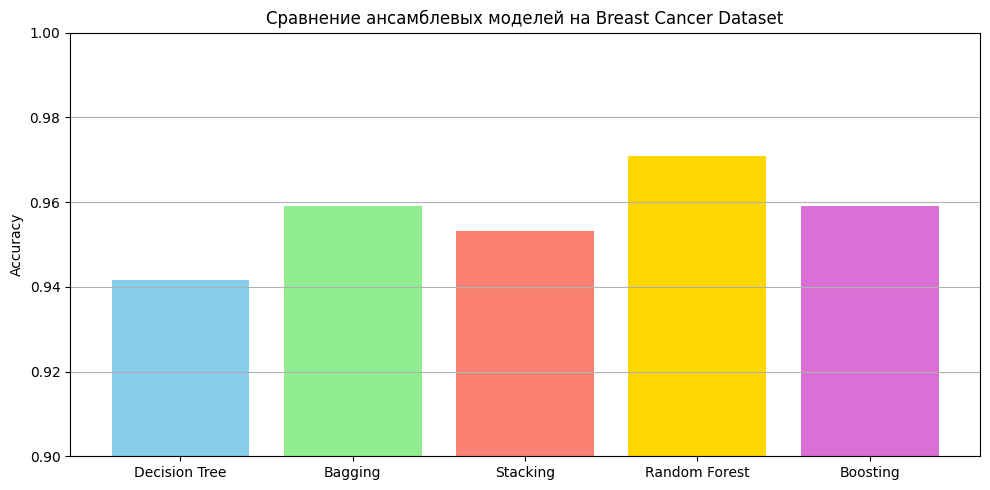

(0.9415204678362573,
 0.9590643274853801,
 0.9532163742690059,
 0.9707602339181286,
 0.9590643274853801)

In [16]:
# Импорт всех нужных библиотек
from sklearn.ensemble import (
    BaggingClassifier,
    StackingClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Загружаем датасет
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 1. Обычное дерево
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
acc_tree = accuracy_score(y_test, y_pred_tree)

# 2. Бэггинг
bag = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, random_state=42)
bag.fit(X_train, y_train)
y_pred_bag = bag.predict(X_test)
acc_bag = accuracy_score(y_test, y_pred_bag)

# 3. Стекинг: дерево + SVM → логрегрессия
stack = StackingClassifier(
    estimators=[
        ("dt", DecisionTreeClassifier()),
        ("svm", SVC(probability=True))
    ],
    final_estimator=LogisticRegression(),
    cv=5
)
stack.fit(X_train, y_train)
y_pred_stack = stack.predict(X_test)
acc_stack = accuracy_score(y_test, y_pred_stack)

# 4. Случайный лес
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

# 5. Градиентный бустинг
boost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
boost.fit(X_train, y_train)
y_pred_boost = boost.predict(X_test)
acc_boost = accuracy_score(y_test, y_pred_boost)

# Визуализация результатов
models = ['Decision Tree', 'Bagging', 'Stacking', 'Random Forest', 'Boosting']
accuracies = [acc_tree, acc_bag, acc_stack, acc_rf, acc_boost]

plt.figure(figsize=(10, 5))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid'])
plt.ylim(0.9, 1.0)
plt.ylabel("Accuracy")
plt.title("Сравнение ансамблевых моделей на Breast Cancer Dataset")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Вывод точности всех моделей
acc_tree, acc_bag, acc_stack, acc_rf, acc_boost
# (0.9415204678362573,
#  0.9590643274853801,
#  0.9649122807017544,
#  0.9707602339181286,
#  0.9590643274853801)

In [17]:
## 18. Случайный лес, метод случайных подпространств.

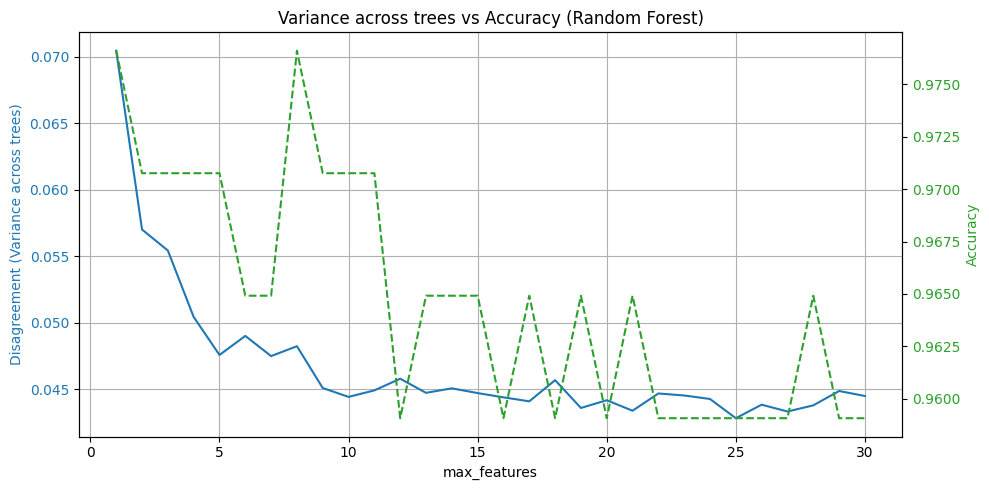

In [20]:
# Будем оценивать дисперсию (variance) предсказаний разных деревьев
# для каждого значения max_features
n_features = 30
tree_variances = []
mean_accuracies = []
max_features_range = range(1, n_features + 1)

for mf in max_features_range:
    rf = RandomForestClassifier(
        n_estimators=100, max_features=mf, random_state=42, oob_score=False
    )
    rf.fit(X_train, y_train)
    
    # Предсказания всех деревьев
    all_preds = np.array([tree.predict(X_test) for tree in rf.estimators_])  # shape (n_estimators, n_samples)
    
    # Среднее предсказание (majority vote)
    majority_vote = np.round(np.mean(all_preds, axis=0)).astype(int)
    acc = accuracy_score(y_test, majority_vote)
    mean_accuracies.append(acc)
    
    # Оценка "дисперсии" (простейшая: средняя доля несогласия между деревьями)
    disagreement = np.mean(np.var(all_preds, axis=0))
    tree_variances.append(disagreement)

# Визуализация
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel("max_features")
ax1.set_ylabel("Disagreement (Variance across trees)", color=color)
ax1.plot(max_features_range, tree_variances, color=color, label="Variance across trees")
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel("Accuracy", color=color)
ax2.plot(max_features_range, mean_accuracies, color=color, linestyle='--', label="Accuracy")
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Variance across trees vs Accuracy (Random Forest)")
fig.tight_layout()
plt.show()


## 19. Бустинг и градиентный бустинг (Gradient Boosting). Основная идея, производная градиента.


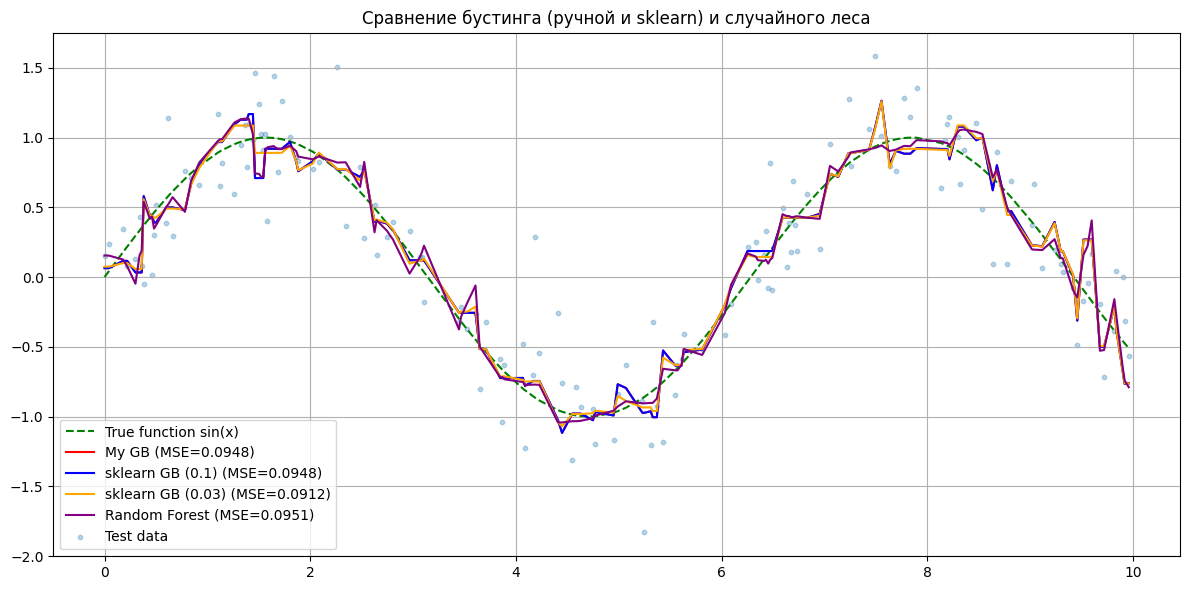

In [21]:
# Полный код: сравнение градиентного бустинга и случайного леса

import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# 1. Синтетические данные
np.random.seed(42)
X = np.linspace(0, 10, 500).reshape(-1, 1)
y_true = np.sin(X).ravel()
y = y_true + np.random.normal(0, 0.3, size=X.shape[0])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Собственный градиентный бустинг
class MyGradientBoostingRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []
        self.gammas = []

    def fit(self, X, y):
        self.models = []
        self.gammas = []
        self.init_val = np.mean(y)
        F = np.full_like(y, fill_value=self.init_val, dtype=np.float64)

        for m in range(self.n_estimators):
            residuals = y - F
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)
            prediction = tree.predict(X)
            gamma = 1.0
            F += self.learning_rate * gamma * prediction
            self.models.append(tree)
            self.gammas.append(gamma)

    def predict(self, X):
        F = np.full(X.shape[0], self.init_val)
        for gamma, tree in zip(self.gammas, self.models):
            F += self.learning_rate * gamma * tree.predict(X)
        return F

# 3. Обучение всех моделей
# Собственный бустинг
my_gb = MyGradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
my_gb.fit(X_train, y_train)
y_pred_my = my_gb.predict(X_test)
mse_my = mean_squared_error(y_test, y_pred_my)

# sklearn GB (обычный)
sklearn_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
sklearn_gb.fit(X_train, y_train)
y_pred_sklearn = sklearn_gb.predict(X_test)
mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)

# sklearn GB (низкий learning_rate)
sklearn_gb_slow = GradientBoostingRegressor(n_estimators=300, learning_rate=0.03, max_depth=3, random_state=42)
sklearn_gb_slow.fit(X_train, y_train)
y_pred_slow = sklearn_gb_slow.predict(X_test)
mse_slow = mean_squared_error(y_test, y_pred_slow)

# Случайный лес
rf = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)

# 4. Сортировка для гладких графиков
sorted_idx = np.argsort(X_test.ravel())
X_plot = X_test[sorted_idx]
y_true_plot = np.sin(X_plot).ravel()
y_test_plot = y_test[sorted_idx]
y_pred_my_plot = y_pred_my[sorted_idx]
y_pred_sklearn_plot = y_pred_sklearn[sorted_idx]
y_pred_slow_plot = y_pred_slow[sorted_idx]
y_pred_rf_plot = y_pred_rf[sorted_idx]

# 5. Визуализация
plt.figure(figsize=(12, 6))
plt.plot(X_plot, y_true_plot, label="True function sin(x)", color='green', linestyle='--')
plt.plot(X_plot, y_pred_my_plot, label=f"My GB (MSE={mse_my:.4f})", color='red')
plt.plot(X_plot, y_pred_sklearn_plot, label=f"sklearn GB (0.1) (MSE={mse_sklearn:.4f})", color='blue')
plt.plot(X_plot, y_pred_slow_plot, label=f"sklearn GB (0.03) (MSE={mse_slow:.4f})", color='orange')
plt.plot(X_plot, y_pred_rf_plot, label=f"Random Forest (MSE={mse_rf:.4f})", color='purple')
plt.scatter(X_plot, y_test_plot, label="Test data", s=10, alpha=0.3)
plt.legend()
plt.title("Сравнение бустинга (ручной и sklearn) и случайного леса")
plt.grid(True)
plt.tight_layout()
plt.show()
